In [179]:
import pysindy as ps

import deepSI
from deepSI.fit_systems import SS_encoder_general
from deepSI.fit_systems.encoders import default_encoder_net, default_state_net, default_output_net

import torch
from torch import nn

import numpy as np

from sklearn.preprocessing import PolynomialFeatures

from scipy.io import loadmat
import os

import deepSI
from deepSI import System_data

from utils import load_data

import matplotlib.pyplot as plt

In [180]:
x_data, u_data, y_data, th_data = load_data(pc=0, set="SILVERSIN")

train, test = System_data(u=u_data[:100000,0],y=x_data[:100000,:]), System_data(u=u_data[-10000:,0],y=x_data[-10000:,:])

train.y.shape, train.u.shape, test.y.shape, test.u.shape

((100000, 2), (100000,), (10000, 2), (10000,))

In [181]:
class SS_encoder_general_eq(SS_encoder_general):
    def __init__(self, nx=10, na=20, nb=20, feedthrough=False, \
        e_net=default_encoder_net, f_net=default_state_net, h_net=default_output_net, \
        e_net_kwargs={},           f_net_kwargs={},         h_net_kwargs={}, na_right=0, nb_right=0, \
        gamma=1e-4):

        super(SS_encoder_general_eq, self).__init__()
        self.nx, self.na, self.nb = nx, na, nb
        self.k0 = max(self.na,self.nb)
        
        self.e_net = e_net
        self.e_net_kwargs = e_net_kwargs

        self.f_net = f_net
        self.f_net_kwargs = f_net_kwargs

        self.h_net = h_net
        self.h_net_kwargs = h_net_kwargs

        self.feedthrough = feedthrough
        self.na_right = na_right
        self.nb_right = nb_right
        ######################################
        # args added for feature transform and
        # regurlarization
        self.gamma = gamma
        ######################################

    def init_nets(self, nu, ny): # a bit weird
        na_right = self.na_right if hasattr(self,'na_right') else 0
        nb_right = self.nb_right if hasattr(self,'nb_right') else 0
        self.encoder = self.e_net(nb=(self.nb+nb_right), nu=nu, na=(self.na+na_right), ny=ny, nx=self.nx, **self.e_net_kwargs)
        ######################################
        ###### change fn intialization #######
        self.fn     =      self.f_net(nx=self.nx, nu=nu, **self.f_net_kwargs)
        ######################################
        if self.feedthrough:
            self.hn =      self.h_net(nx=self.nx, ny=ny, nu=nu,                     **self.h_net_kwargs) 
        else:
            self.hn =      self.h_net(nx=self.nx, ny=ny,                            **self.h_net_kwargs) 

    def loss(self, uhist, yhist, ufuture, yfuture, loss_nf_cutoff=None, **Loss_kwargs):
        #####################################################
        if isinstance(Loss_kwargs.get('encoder_off'), bool) and Loss_kwargs.get('encoder_off'):
            # In the case the encoder is removed from the process
            yh_shape = yhist.shape
            yhist = yfuture[:,0,:]  # select current state as initial state
            yhist = torch.reshape(yhist, yh_shape)
        #####################################################
        x = self.encoder(uhist, yhist) #initialize Nbatch number of states
        
        errors = []
        for y, u in zip(torch.transpose(yfuture,0,1), torch.transpose(ufuture,0,1)): #iterate over time
            error = nn.functional.mse_loss(y, self.hn(x,u) if self.feedthrough else self.hn(x))
            # TODO: add regurlization
            errors.append(error) #calculate error after taking n-steps
            if loss_nf_cutoff is not None and error.item()>loss_nf_cutoff:
                print(len(errors), end=' ')
                break
            x = self.fn(x,u) #advance state.

        return torch.mean(torch.stack(errors))

In [182]:
class h_identity(nn.Module):
    """ Output network which is just identity passes all input directly to output.

        Attributes:
            args        : To allow working with SUBNET
            kwargs      : To allow working with SUBNET

        Methods:
            __init__(self, *args, **kwargs):
                Constructor method

            forward(self, input):
                Method is neccesary for working with SUBNET as SUBNET calls forward on this network.
    """
    # TODO: add check for output and input dimension and raise exception when not equal. Currently only works with fully state information and output is considered just to be the state.
    def __init__(self, *args, **kwargs):
        super().__init__()

    def forward(self, input):
        return input
    
class e_identity(nn.Module):
    """ Identity encoder class. Given full state information passes directly to f network in simplified case.

        Attributes:
            args        : To allow working with SUBNET
            kwargs      : To allow working with SUBNET

        Methods:
            __init__(self, *args, **kwargs):
                Constructor method

            forward(self, input):
                Method is neccesary for working with SUBNET as SUBNET calls forward on this network.
    """
    def __init__(self, *args, **kwargs):
        super().__init__()

    def forward(self, *input):
        # SUBNET stack the control input and state information as (u,x) therefore only the last input is passed directly to output.
        output = input[-1]
        output = torch.reshape(output,(output.shape[0], output.shape[-1]))
        return output
    
class simple_Linear(torch.nn.Module):
    """ Neural network linear in the parameters e.g. with a single linear layer. The input to the network is the state information and the input(x,u) transformed by the feature library. This is a seperate class that transforms the input with a specified function library.

        Attributes:
            nx          : The state dimension of data passed through the system.
            nu          : Neccesary to work with SUBNET.
            kwargs      : Used to set dimensions of nu and choosing function library.

        Methods:
            __init__(self, nx, nu, **kwargs):
                Constructor method.

            forward(self, x, u):
                forward used by torch.nn.Module which handels forward passes through the network. x is the state information and u is the control input.
    """
    def __init__(self, nx, nu, **kwargs):
        super(simple_Linear, self).__init__()

        self.nx = nx
        self.nu = kwargs['u']

        self.feature_library = kwargs['feature_library']
        self.nf = self.feature_library.feature_number()
        
        self.layer = nn.Linear(self.nf, nx, bias=False)
        

    def forward(self, x, u):
        # make sure u is column
        u = torch.reshape(u, (u.shape[-1],1))
        x = torch.hstack((x, u))
        Theta = self.feature_library.fit_transform(x)
        out = self.layer(Theta)
        return out

In [183]:
class feature_library():
    """ Class object that holds the features for constructing the functions basis.

        Attributes:
            functions (list)        : list of function objects
            nx (int)                : the number of states
            nu (int)                : the number of inputs
            include_one (bool)      : choose to include an offset
            interaction_only (bool) : true exlcudes terms such as x1[k]*x2[k]

        Methods:
            __init__(self, functions, nx, nu, include_one, interaction_only):
                Constructor

            fit_transform(self, X):
                Transforms data in X using the specified functions stored in self.functions.

            feature_names(self):
                Returns a list of strings which correspond to the features in self.functions.

            feature_number(self):
                Returns the number of features that will be produced by transformation.

    """
    def __init__(
            self,
            functions,
            nx,
            nu,
            include_one = True,
            interaction_only=True
    ):
        self.functions = functions
        # TODO: add interaction only to include/exclude cross terms
        # now functions are applied to all states and inputs
        self.interaction_only = interaction_only

        # set to false to exclude possible offset
        self.include_one = include_one

        # state and input dimensions
        self.nx = nx
        self.nu = nu

        # creates list of factors that are in system
        # x0[k],..., xn[k], u0[k],..., un[k]
        self.term_list = [f"x{i}[k]" for i in range(self.nx)]
        input_list = [f"u{i}[k]" for i in range(self.nu)]
        self.term_list.extend(input_list)

    def fit_transform(self, X):
        # if include_one = True add term for offset
        out_feature = ((X[:,0])**0).unsqueeze(1) if self.include_one else torch.empty(X.shape[0], 1)
        if self.interaction_only:
            for f in self.functions:
                out_feature = torch.hstack((out_feature, f(X)[0]))
            return out_feature
        # TODO: add the stuff for cross terms
        
    def feature_names(self):
        # returns list with feature names
        flist = ["1"] if self.include_one else []
        for f in self.functions:
            for x in self.term_list:
                flist.append(f(torch.tensor(1.),f"{x}")[-1])
        return flist
    
    def feature_number(self):
        if self.interaction_only:
            fnum =  len(self.functions*(self.nx+self.nu))
        # TODO: add functionality for cross features when interaction only is false

        return fnum+self.include_one

In [184]:
def f(x, name="_"):
  """ f(x) = x """
  return x, f"{name}"

def f2(x, name="_"):
  """ f(x) = x**2 """
  return x**2, f"{name}**2"

def f3(x, name="_"):
  """ f(x) = x**3 """
  return x**3, f"{name}**3"

def sin(x, name="_"):
  """ f(x) = sin(x) """
  return torch.sin(x), f"sin({name})"

In [185]:
functions = [f, sin]

poly = feature_library(functions=functions, nx=2, nu=1)

In [186]:
# fit_sys = deepSI.fit_systems.SS_encoder_general(nx=2, na=50, nb=50)

nx, nu = 2, 1 # state dimension and inputs
na, nb = 1, 0

f_net = simple_Linear
f_net_kwargs = {"feature_library": poly, "u": nu, "nf": 7}

# e_net_kwargs = {"slot": 1}

h_net = h_identity
h_net_kwargs = {}

e_net = e_identity
e_net_kwargs = {}

fit_sys = SS_encoder_general_eq(nx=nx, na=na, nb=nb, \
                                f_net=f_net, f_net_kwargs=f_net_kwargs,\
                                e_net=e_net, e_net_kwargs=e_net_kwargs,\
                                h_net=h_net)


fit_sys.fit(train, test, epochs=4, batch_size = 99998, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=dict(nf=2, encoder_off=True), auto_fit_norm=False)

Initilizing the model and optimizer
Size of the training array =  6.1 MB
N_training_samples = 99998, batch_size = 99998, N_batch_updates_per_epoch = 1
Initial Validation sim-NRMS= 1.0011408785728233


 25%|██▌       | 1/4 [00:01<00:05,  1.72s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 1.0011029260291688
Epoch    1, sqrt loss   1.806, Val sim-NRMS  1.001, Time Loss: 1.9%, data: 0.7%, val: 97.4%,  1.7 sec/batch


 50%|█████     | 2/4 [00:03<00:03,  1.63s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 1.001065923272698
Epoch    2, sqrt loss   1.804, Val sim-NRMS  1.001, Time Loss: 1.1%, data: 0.7%, val: 98.2%,  1.6 sec/batch


 75%|███████▌  | 3/4 [00:04<00:01,  1.63s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 1.001030189487052
Epoch    3, sqrt loss   1.801, Val sim-NRMS  1.001, Time Loss: 1.4%, data: 0.8%, val: 97.8%,  1.6 sec/batch


 75%|███████▌  | 3/4 [00:05<00:01,  1.84s/it]

Stopping early due to a KeyboardInterrupt
Loaded model with best known validation sim-NRMS of  1.001 which happened on epoch 3 (epoch_id=3.00)


In [ ]:
found = [*fit_sys.fn.parameters()][0].detach().numpy()

found

array([[ 0.22685757, -0.13102551,  0.08883731,  0.16081834, -0.37826842,
        -0.11862017,  0.2553448 ],
       [-0.2536538 , -0.20727262,  0.3596559 ,  0.04312349,  0.16933866,
        -0.13189794,  0.25552112]], dtype=float32)

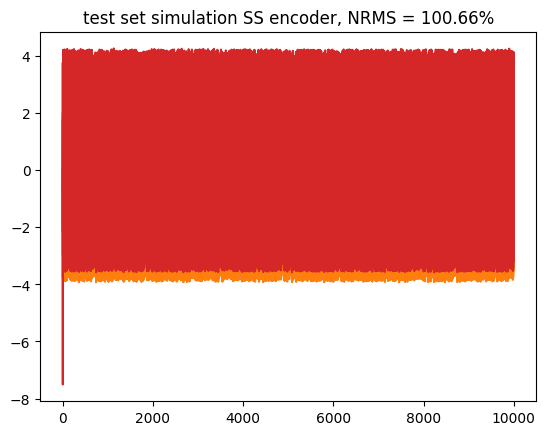

In [ ]:
test_sim_enc = fit_sys.apply_experiment(test)

plt.plot(test.y)
plt.plot(test.y - test_sim_enc.y)
plt.title(f'test set simulation SS encoder, NRMS = {test_sim_enc.NRMS(test):.2%}')
plt.show()

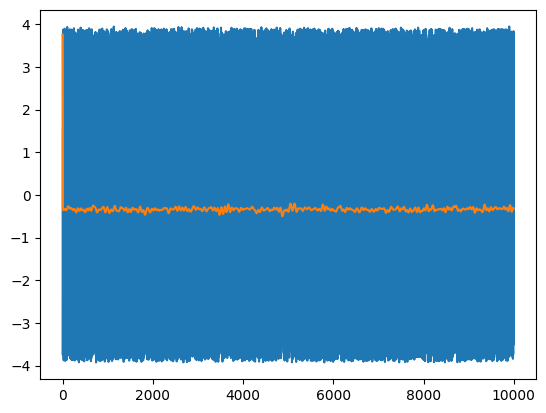

In [ ]:
plt.plot(test.y[:,1])
plt.plot(test_sim_enc.y[:,1])

In [ ]:
# def NRMS(y_pred, y_true):
#     RMS = np.sqrt(np.mean((y_pred-y_true)**2))
#     return RMS/np.std(y_true)

In [ ]:
# plt.plot(test.y[:,0])
# plt.plot(test.y[:,0]-test_sim_enc.y[:,0],'--')
# plt.title(f'test set simulation SS encoder, NRMS = {NRMS(test_sim_enc.y[:,0],test.y[:,0]):.2%}')
# plt.show()

# plt.plot(test.y[:,1])
# plt.plot(test.y[:,1]-test_sim_enc.y[:,1],'--')
# plt.title(f'test set simulation SS encoder, NRMS = {NRMS(test_sim_enc.y[:,1],test.y[:,1]):.2%}')
# plt.show()

In [ ]:
# plt.plot(test_sim_enc.y[:,1],'--')
# plt.plot(test.y[:,1])

In [ ]:
# found = [*fit_sys.fn.parameters()][0].detach().numpy()
# true = np.array([[0, 1, 1, 0, 0, 0, 0],[0, -0.1, 0.5, 0.1, -0.2, 0, 0]])

In [ ]:
# from matplotlib.colors import LinearSegmentedColormap

In [ ]:
# fig, (ax1,ax2) = plt.subplots(2, 1)

# x_labels = ["1","x0[k]","x1[k]","u[k]","sin(x0[k])","sin([x1[k]])","sin(u[k])"]

# data1 = np.vstack((true[0,:],found[0,:]))
# data2 = np.vstack((true[1,:],found[1,:]))
# cmap_white = LinearSegmentedColormap.from_list("white", [(1, 1, 1), (1, 1, 1)])

# im = ax1.imshow(data1, cmap=cmap_white)

# ax1.set_xticks(np.arange(data1.shape[1]), labels=x_labels, rotation=25)
# ax1.set_yticks(np.arange(data1.shape[0]), labels=["True", "Found"])

# for i in range(data1.shape[0]):
#     for j in range(data1.shape[1]):
#         text = ax1.text(j, i, round(data1[i, j],3),
#                        ha="center", va="center", color="k")
#         rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=1)
#         ax1.add_patch(rect)

# ax1.patch.set_linewidth(2.0)        
# ax1.patch.set_edgecolor('black')

# # second
# im = ax2.imshow(data2, cmap=cmap_white)

# ax2.set_xticks(np.arange(data2.shape[1]), labels=x_labels, rotation=25)
# ax2.set_yticks(np.arange(data2.shape[0]), labels=["True", "Found"])

# for i in range(data2.shape[0]):
#     for j in range(data2.shape[1]):
#         text = ax2.text(j, i, round(data2[i, j], 3),
#                        ha="center", va="center", color="k")
#         rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=1)
#         ax2.add_patch(rect)

# ax2.patch.set_linewidth(2.0)        
# ax2.patch.set_edgecolor('black')

# plt.show()